In [1]:
import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [2]:
import json

# Load the label mapping
with open('./content/squeezenet-labels.json') as f:
    label_mapping = json.load(f)


In [4]:
model = models.squeezenet1_1(pretrained=True)

/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/highorder/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
input_image = "./content/dog.png"  # Provide the path to your input image
image = Image.open(input_image).convert("RGB")  # Convert image to RGB format
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

processed_image = preprocess(image).unsqueeze(0)

In [6]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

def print_top_predictions(output, label_mapping, top_k=5):
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)

    print("Top 5 Predictions:")
    for i in range(top5_prob.size(0)):
        label = label_mapping[str(top5_catid[i].item())]
        percentage = top5_prob[i].item() * 100
        print(f'{label}: {percentage:.2f}%')

def show_image_and_predictions(image, output, label_mapping, top_k=5):
    # Check if the image has 4 dimensions and squeeze if necessary
    if image.dim() == 4:
        image = image.squeeze(0)
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    
    # Get the top predictions
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)
    
    # Print the top predictions
    print_top_predictions(output, label_mapping, top_k)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # Reverse the normalization
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))



In [7]:
def attack_BIM(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''

    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index])

    # Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 224, 224]))
    assert(class_index.shape == torch.Size([1]))
    
    # Initialize adversarial image as image according to equation 2.1
    image_adver = image.clone()    
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)

    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        # Compute cost with example image_adversarial        
        pred = model(image_adver)        
        loss = F.nll_loss(pred, class_index)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 2.2
        image_prime = image_adver + alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 2.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 2.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    return image_adver

In [8]:
import torch.nn.functional as F


In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
epsilon = 0.025
alpha = 0.01
num_iterations = 10
class_index = torch.tensor([235])  # Example class index

def reverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverse the normalization of a tensor.
    
    Args:
    - tensor (torch.Tensor): The normalized tensor.
    - mean (list): The mean used for normalization.
    - std (list): The standard deviation used for normalization.
    
    Returns:
    - torch.Tensor: The unnormalized tensor.
    """
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean



# Call the attack_BIM function
adversarial_image = attack_BIM(mean, std, model, processed_image, class_index, epsilon, alpha, num_iterations)



In [10]:
adversarial_image_unnormalized = reverse_normalize(adversarial_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


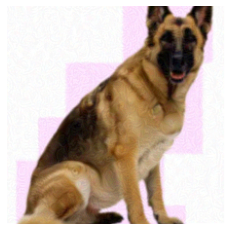

Top 5 Predictions:
necklace: 8.58%
vestment: 4.46%
abacus: 2.89%
chain: 2.63%
purse: 2.45%


In [11]:
show_image_and_predictions(adversarial_image_unnormalized, model(adversarial_image), label_mapping, top_k=5)

In [12]:


# Convert image to tensor
image_tensor = transforms.ToTensor()(image)


In [13]:
print(f"Size of image_tensor: {processed_image.size()}")
print(f"Size of adversarial_image_unnormalized: {adversarial_image.size()}")


Size of image_tensor: torch.Size([1, 3, 224, 224])
Size of adversarial_image_unnormalized: torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


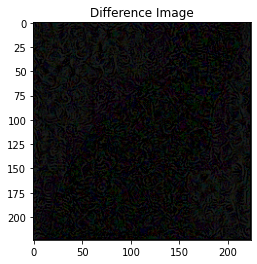

In [25]:
difference_image = (processed_image - adversarial_image).squeeze(0)
squared_difference_image = difference_image ** 2
# Plot the resulting difference
plt.imshow(difference_image.permute(1, 2, 0).cpu().detach().numpy())
plt.title('Difference Image')
plt.show()